In [ ]:
!pip install kaggle

In [2]:
import kagglehub
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,ConfusionMatrixDisplay
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [ ]:
path = kagglehub.dataset_download("yashpaloswal/fraud-detection-credit-card")
print("Path to dataset files:", path)

for filename in os.listdir(path):
    if filename.endswith(".csv"):
        filepath = os.path.join(path, filename)
        try:
            df = pd.read_csv(filepath)
            print(f"Successfully loaded {filename} into a DataFrame.")
            break  # Assuming only one CSV file in the dataset
        except pd.errors.ParserError:
            print(f"Error parsing {filename}. Skipping this file.")
        except Exception as e:
            print(f"An error occurred while loading {filename}: {e}")

df_backup = df.copy()

In [5]:
def scale_features(df):
  scaler = StandardScaler()
  df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
  df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
  return df

In [9]:
df = scale_features(df)

# Temporal train-test split
split_time = df['Time'].quantile(0.8)
train_df = df[df['Time'] <= split_time]
test_df = df[df['Time'] > split_time]

X_train = train_df.drop(columns=['class'])
y_train = train_df['class']
X_test = test_df.drop(columns=['class'])
y_test = test_df['class']

print(X_train)

            Time        V1        V2        V3        V4        V5        V6  \
0            0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1            0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2            1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3            1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4            2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   
...          ...       ...       ...       ...       ...       ...       ...   
227840  145244.0  2.028950 -0.374089 -1.268051  0.349127 -0.057977 -0.515489   
227841  145245.0  0.306600  1.116021 -0.047348  3.593785  2.079047  5.748707   
227842  145245.0 -1.781954  2.062680 -3.758871 -1.801001 -0.084365  1.919610   
227843  145245.0 -0.061507  1.024900 -0.170060 -0.263220  0.982164 -1.162749   
227844  145247.0  2.050034 -0.103557 -1.204713  0.207198  0.108850 -0.665621   

              V7        V8        V9  .

In [10]:
# SMOTE
#smote = SMOTE(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# SMOTE Tomek
#smote = SMOTETomek(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_resampled, y_resampled = X_train, y_train


 Model: XGB CLassifier


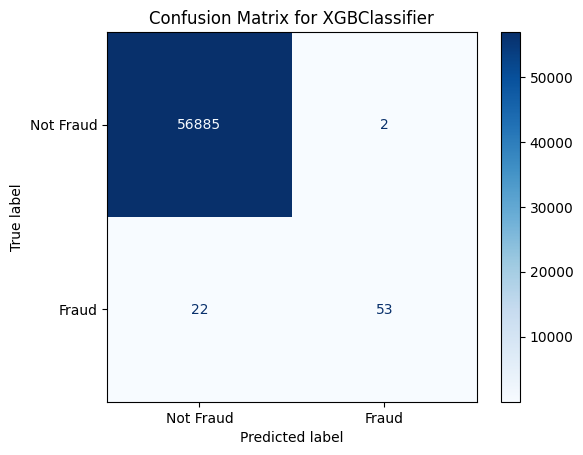


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.96      0.71      0.82        75

    accuracy                           1.00     56962
   macro avg       0.98      0.85      0.91     56962
weighted avg       1.00      1.00      1.00     56962



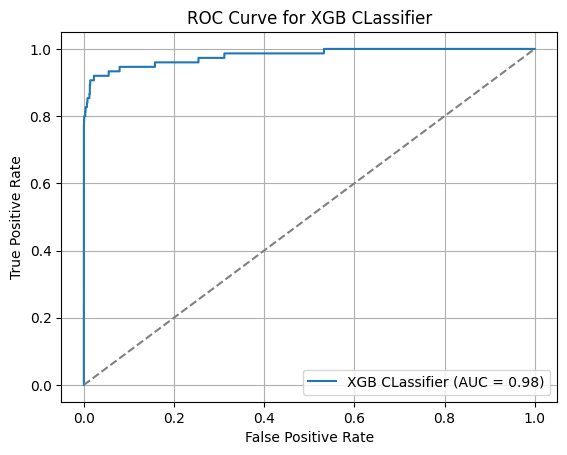


 Model: Logistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


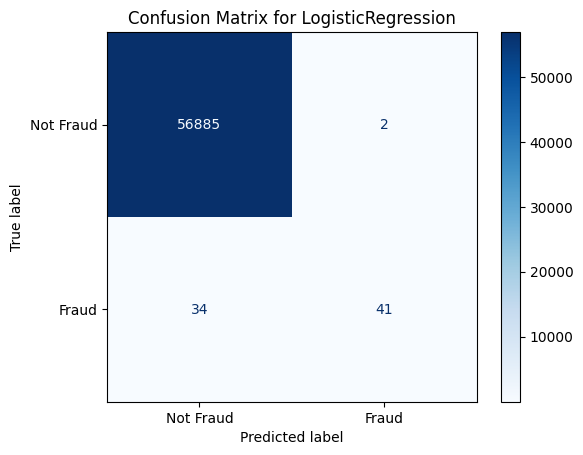


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.95      0.55      0.69        75

    accuracy                           1.00     56962
   macro avg       0.98      0.77      0.85     56962
weighted avg       1.00      1.00      1.00     56962



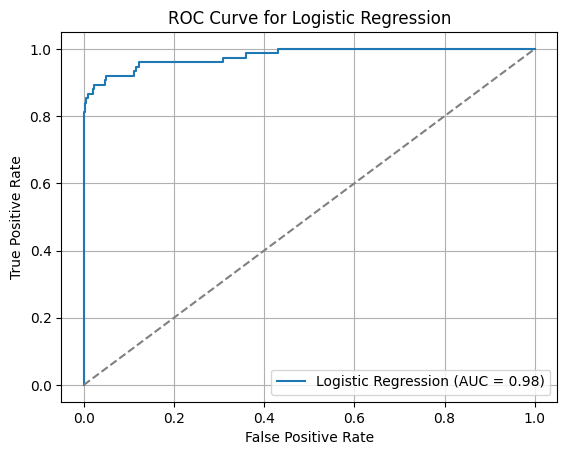


 Model: LGBM Classifier
[LightGBM] [Info] Number of positive: 417, number of negative: 227428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001830 -> initscore=-6.301503
[LightGBM] [Info] Start training from score -6.301503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


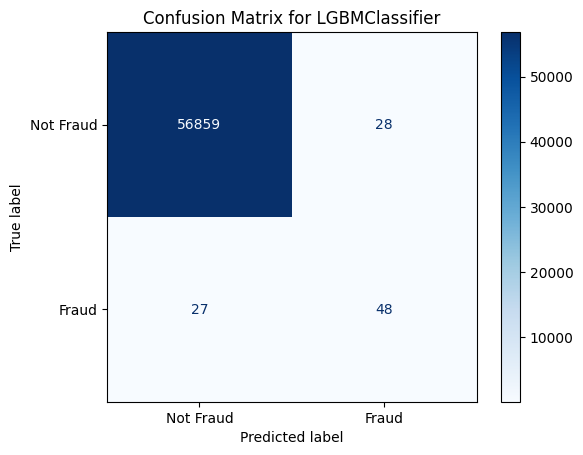


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.63      0.64      0.64        75

    accuracy                           1.00     56962
   macro avg       0.82      0.82      0.82     56962
weighted avg       1.00      1.00      1.00     56962



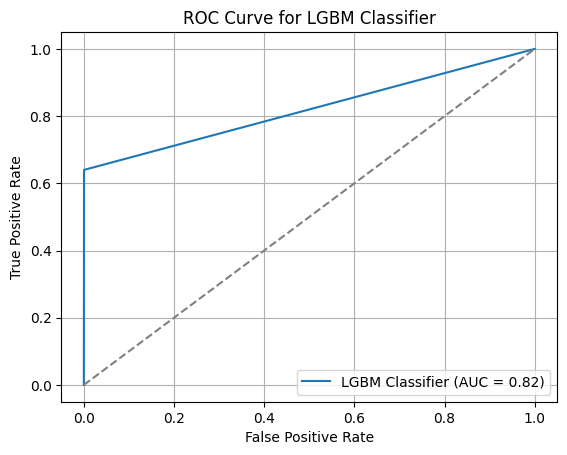

In [11]:
def run_models(df, models):

    for name, model in models.items():
        print(f"\n Model: {name}")
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
        cm_display.plot(cmap='Blues')
        plt.title(f"Confusion Matrix for {model.__class__.__name__}")
        plt.show()

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))


        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:, 1]
        else:
            y_scores = model.decision_function(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_scores)
        auc = roc_auc_score(y_test, y_scores)

        plt.figure()
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {name}')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

models = {
    'XGB CLassifier': XGBClassifier(n_estimators=200, random_state=42, eval_metric='logloss'),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'LGBM Classifier': lgb.LGBMClassifier(n_estimators=200, random_state=42)
    #'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

run_models(df, models)